# RFM Customer Segmentation Project

RFM (Recency, Frequency, and Monetary) analysis is a popular method for customer segmentation that helps businesses understand customer behavior and target them more effectively. It's used primarily to evaluate customer value and predict future purchasing behavior by analyzing three key aspects:

- Recency (R): How recently a customer made a purchase. Customers who have purchased recently are generally more likely to buy again compared to those who haven't purchased in a long time.

- Frequency (F): How often a customer makes a purchase. A high-frequency customer is often a loyal customer, which can lead to higher lifetime value.

- Monetary (M): How much money a customer spends. Customers who spend more are considered high-value and should be prioritized in retention and upselling strategies.

## Data Dictionary

UCI Online Retail Dataset

This is a transnational data set which contains all the transactions occurring from December 1st 2010 until December 9th 2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents ID.

Source: http://archive.ics.uci.edu/ml/datasets/Online+Retail (Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.)

In [ ]:
import pandas as pd
# Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

# Data Description for each column
column_description = pd.DataFrame({
    'Column Name':['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
    ,'Description':[
        'Invoice number.If this code starts with letter "c", it indicates a cancellation.'
        ,'Product (item) code'
        ,'Product (item) name.'
        ,'The quantities of each product (item) per transaction.'
        ,'Invice Date and time'
        ,'Unit price'
        ,'Customer number'
        ,'Country name'
    ]
    ,'Data Type':[
        'Nominal, a 6-digit integral number uniquely assigned to each transaction'
        ,'Nominal, a 5-digit integral number uniquely assigned to each distinct product'
        ,'Nominal'
        ,'Numeric'
        ,'Numeric, the day and time when each transaction was generated'
        ,'Numeric, Product price per unit in sterling'
        ,'Nominal, a 5-digit integral number uniquely assigned to each customer'
        ,'Nominal, the name of the country where each customer reside'
    ]
})
column_description

# I. Data Validation

This process involves checking for errors, inconsistencies, and missing values in the data to ensures the accuracy, quality, and integrity of the data by checking duplicates, missing data, structural errors, outliers of the dataset.

Data Validation is necessary to produce clean and reliable data that is ready for analysis or further processing.

## 1.1. Import the necessary libraries

In [84]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

# display full outputs in Jupyter Notebook, not only the last command's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1.2. Load the dataset

In [85]:
# read the data
ecommerce_data = pd.read_csv(r'data\\E-Commerce Data.csv', encoding='ISO-8859-1')
ecommerce_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 1.3. Removing Duplicates

In [86]:
print(f'Number of duplicated rows: {ecommerce_data.duplicated().sum()}')

Number of duplicated rows: 5268


In [87]:
# duplicate sample row
ecommerce_data[ecommerce_data.duplicated()].iloc[0]

InvoiceNo                           536409
StockCode                            21866
Description    UNION JACK FLAG LUGGAGE TAG
Quantity                                 1
InvoiceDate                12/1/2010 11:45
UnitPrice                             1.25
CustomerID                         17908.0
Country                     United Kingdom
Name: 517, dtype: object

In [88]:
ecommerce_data[(ecommerce_data['InvoiceNo'] == '536409') & (ecommerce_data['StockCode'] == '21866')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom


Those duplicated records can skew our analysis. Therefore, let's drop these records.

In [89]:
ecommerce_data.drop_duplicates(inplace=True)
print(f'Number of duplicated rows: {ecommerce_data.duplicated().sum()}')

Number of duplicated rows: 0


## 1.4. Handling Missing Data

In [90]:
missing_data = ecommerce_data.isnull().sum().to_frame().rename(columns={0: 'total'})
missing_data['percent'] = (missing_data['total'] / ecommerce_data.shape[0]) * 100   
missing_data

,total,percent
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.270945
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135037,25.163377
Country,0,0.000000


CustomerID has the highest null value taking up to 25% of total records, we can try:
1. Drop all null value rows
2. Try to find ways to fill those Nan values

With option 2 in mind, I have a theory to fill in values. For example, InvoiceNo A has CustomerID A and Customer null, I can replace these NaN CustomerID with existing CustomerID A since it's just missing input error. 

If option 2 failed, I will do option 1 which is dropping all null value rows for further analysis.

In [91]:
null_df = ecommerce_data[ecommerce_data['CustomerID'].isnull()]
null_df.reset_index(drop=True, inplace=True)
null_df.shape
null_df.head()

(135037, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
2,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
3,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
4,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [92]:
not_null_df=ecommerce_data[ecommerce_data['CustomerID'].isnull() == False]
not_null_df.reset_index(drop=True, inplace=True)
not_null_df.shape
not_null_df.head()

(401604, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [93]:
##### Find intersection between 2 dataframes with same InvoiceNo values
null_df[null_df['InvoiceNo'].isin(not_null_df['InvoiceNo'].unique())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


There is no repeated Invoice Number between the not null and the null customerID data. Therefore, we can not perform any imputation here, this leaves us no choice but to remove these null records.

In [94]:
# Drop rows with missing CustomerID
ecommerce_data = ecommerce_data[~ecommerce_data['CustomerID'].isnull()]
ecommerce_data.reset_index(drop=True, inplace=True)
ecommerce_data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [95]:
# Check missing values again
missing_data = ecommerce_data.isnull().sum().to_frame().rename(columns={0: 'total'})
missing_data['percent'] = (missing_data['total'] / ecommerce_data.shape[0]) * 100   
missing_data

,total,percent
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0


## 1.5. Datetime Datatype Conversion

According to the Description of the Dataset, InvoiceDate is the only column containing datetime datatype and is extremely crucial for generating Recency, Frequency feature of RFM Analysis.

In [96]:
import datetime # datetime manipulation

# validate date format
def validate_datetime(d):
    try:
        datetime.datetime.strptime('4/21/2011 19:05', '%m/%d/%Y %H:%M')
        return True
    except ValueError:
        return False
    
ecommerce_data[~ecommerce_data['InvoiceDate'].apply(lambda x: validate_datetime(x))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


So our datetime data is validated with '%m/%d/%Y %H:%M' format, let's convert them from object to datetime

In [97]:
# datetime conversion
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'],format='%m/%d/%Y %H:%M')
ecommerce_data['InvoiceDate'].describe()

count                           401604
mean     2011-07-10 12:08:23.848567552
min                2010-12-01 08:26:00
25%                2011-04-06 15:02:00
50%                2011-07-29 15:40:00
75%                2011-10-20 11:58:30
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

## 1.6. Object Datatype Conversion

Follow the description of dataset, there are 5 Columns containing Nominal datatype:
- InvoiceNo
- StockCode
- Description
- CustomerID
- Country

In [98]:
# Check the number of categorical columns
print(f'There are currently only {ecommerce_data.select_dtypes(include="object").columns.size} Nominal columns\n')

# Check the unique values of each categorical column
for cate_col in ecommerce_data.select_dtypes(include='object').columns:
    print(f'{cate_col}: {ecommerce_data[cate_col].nunique()} unique values')

There are currently only 4 Nominal columns

InvoiceNo: 22190 unique values
StockCode: 3684 unique values
Description: 3896 unique values
Country: 37 unique values


Let's convert CustomerID into Nominal type too.

In [99]:
ecommerce_data['CustomerID'] = ecommerce_data['CustomerID'].astype(int).astype(str)
# Check the number of categorical columns
print(f'There are currently {ecommerce_data.select_dtypes(include="object").columns.size} Nominal columns\n')

# Check the unique values of each categorical column
for cate_col in ecommerce_data.select_dtypes(include='object').columns:
    print(f'{cate_col}: {ecommerce_data[cate_col].nunique()} unique values')

There are currently 5 Nominal columns

InvoiceNo: 22190 unique values
StockCode: 3684 unique values
Description: 3896 unique values
CustomerID: 4372 unique values
Country: 37 unique values


## 1.7. Checking Outliers

In [100]:
ecommerce_data.select_dtypes([int,float]).columns

Index(['Quantity', 'UnitPrice'], dtype='object')

<Figure size 900x600 with 0 Axes>

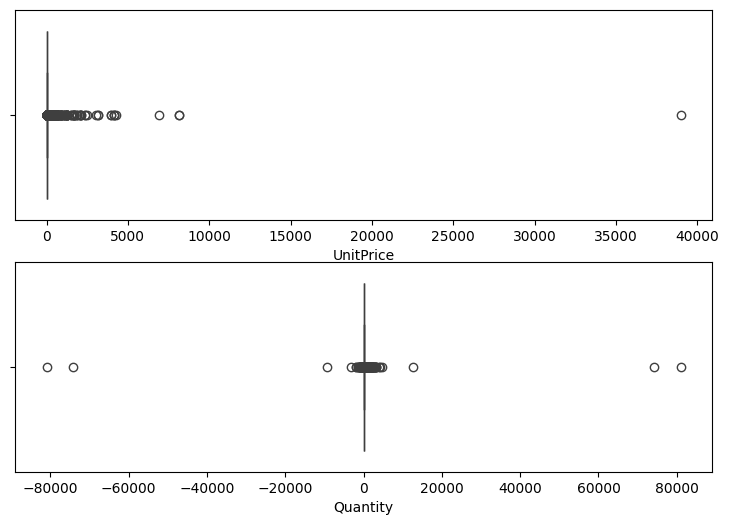

In [101]:
import matplotlib.gridspec as gridspec # subplots

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 1)

# Create a figure
plt.figure(figsize=(9,6))

# add axes_1
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.boxplot(
    data=ecommerce_data.UnitPrice
    ,orient='h'
)

# add axes_2
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=ecommerce_data.Quantity
    ,orient='h'
)

plt.show()

As box plot shown above, there a number of records with negative values of quantity. These negative values could be indicates a cancellation, discount, which from RFM Analysis aspect, we may need some transaction such as discount to reflect the actual customer behaviour. So these negative values could be true outliers, not incorrect, structural errors caused by data entry, processing stages.

# II. Data Filtering

This process involves removing or excluding data that does not meet certain conditions or criteria. Includes filtering based on values, ranges, or conditions (e.g., removing outliers, selecting specific time periods) with the purpose to select only a subset of data based on specific criteria to focus on relevant information in order to produce a refined dataset that contains only the relevant information needed for analysis, in this case, for the RFM analysis.

## 2.1. Non-Product Description

In [102]:
# Check lowercase Description
ecommerce_data[ecommerce_data['Description'].str.contains('[a-z]')]['Description'].value_counts()

Description
Manual                                 460
BAG 125g SWIRLY MARBLES                252
3 TRADITIONAl BISCUIT CUTTERS  SET     207
BAG 250g SWIRLY MARBLES                201
POLYESTER FILLER PAD 40x40cm           185
POLYESTER FILLER PAD 45x45cm           135
BAG 500g SWIRLY MARBLES                115
Next Day Carriage                       80
Discount                                77
FRENCH BLUE METAL DOOR SIGN No          75
POLYESTER FILLER PAD 45x30cm            37
POLYESTER FILLER PAD 30CMx30CM          26
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     18
CRUK Commission                         16
NUMBER TILE COTTAGE GARDEN No           12
Bank Charges                            12
FOLK ART GREETING CARD,pack/12          10
NUMBER TILE VINTAGE FONT No              7
THE KING GIFT BAG 25x24x12cm             7
POLYESTER FILLER PAD 65CMx65CM           5
FLOWERS HANDBAG blue and orange          3
High Resolution Image                    3
POLYESTER FILLER PAD 60x40cm             1

Description such as Manual, Bank Charges, etc is not product, therefore, let's gather these values into a non product list.

In [103]:
not_products = ['Next Day Carriage', 
                'Discount', 
                'CRUK Commission', 
                'Bank Charges', 
                'Manual']

In [104]:
# Check short Description
def short_description(desc):
    return len(desc.split()) < 3
ecommerce_data[
    (ecommerce_data['Description'].apply(lambda x: short_description(x))) &
    (~ecommerce_data['Description'].isin(not_products))
]['Description'].unique()

array(['POSTAGE', 'CHOCOLATE CALCULATOR', 'CHILLI LIGHTS', 'PHOTO CUBE',
       'RETROSPOT LAMP', 'PICTURE DOMINOES', 'DOORMAT TOPIARY',
       'DOORMAT HEARTS', 'WRAP COWBOYS  ', 'FLOWERS  STICKERS',
       'OWL DOORSTOP', 'WICKER STAR ', 'CHRYSANTHEMUM NOTEBOOK',
       'BUTTON BOX ', 'POLKADOT PEN', 'GRAND CHOCOLATECANDLE', 'CARRIAGE',
       'DOORMAT AIRMAIL ', 'NEWSPAPER STAND', 'BINGO SET',
       'CHRYSANTHEMUM SKETCHBOOK ', 'SKULLS  STICKERS', 'GLAMOROUS  MUG',
       'SPACE FROG', 'SPACE OWL', 'DECOUPAGE,GREETING CARD,',
       'DOGGY RUBBER', 'SKULLS TAPE', 'HEARTS  STICKERS', 'PARTY BUNTING',
       'POTTERING MUG', 'SANDALWOOD FAN', 'SOMBRERO ', 'ANIMAL STICKERS',
       'RAIN PONCHO ', 'MIRROR CORNICE', 'CARNIVAL BRACELET',
       'HEART CALCULATOR', 'CHRYSANTHEMUM  JOURNAL',
       'BUTTERFLIES STICKERS', 'TUMBLER, BAROQUE', 'PLASMATRONIC LAMP',
       'DAISY JOURNAL ', 'SWEETIES  STICKERS', 'DAISY NOTEBOOK ',
       'GOLD WASHBAG', 'WOODLAND  STICKERS', 'DAISY SKETCHBOOK

'POSTAGE', 'DOTCOM POSTAGE' and 'CARRIAGE' are not products. So I will have them appended to the not_products list

In [105]:
not_products.append('POSTAGE')
not_products.append('CARRIAGE')
not_products.append('DOTCOM POSTAGE')
not_products

['Next Day Carriage',
 'Discount',
 'CRUK Commission',
 'Bank Charges',
 'Manual',
 'POSTAGE',
 'CARRIAGE',
 'DOTCOM POSTAGE']

Let's review records contain these non-product description

In [106]:
for not_product in not_products:    
    ecommerce_data[ecommerce_data['Description'] == not_product].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
379442,579260,23444,Next Day Carriage,1,2011-11-29 08:41:00,15.0,14618,United Kingdom
318980,573545,23444,Next Day Carriage,1,2011-10-31 13:12:00,15.0,16969,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
70434,C545476,D,Discount,-1,2011-03-03 11:05:00,30.38,14527,United Kingdom
228505,C564812,D,Discount,-1,2011-08-30 11:45:00,15.07,14527,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
254376,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096,United Kingdom
244036,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
377701,579137,BANK CHARGES,Bank Charges,1,2011-11-28 12:51:00,15.0,14704,United Kingdom
300216,571900,BANK CHARGES,Bank Charges,1,2011-10-19 14:26:00,15.0,13263,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173702,558479,M,Manual,2,2011-06-29 16:44:00,2.95,17837,United Kingdom
292585,571223,M,Manual,1,2011-10-14 13:36:00,599.50,13810,Germany


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
138534,C554002,POST,POSTAGE,-1,2011-05-20 12:09:00,6.5,13692,United Kingdom
349430,576519,POST,POSTAGE,1,2011-11-15 12:25:00,40.0,12676,Sweden


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
215045,563355,C2,CARRIAGE,1,2011-08-15 14:39:00,50.0,14156,EIRE
137836,553897,C2,CARRIAGE,1,2011-05-19 17:23:00,50.0,14911,EIRE


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
319263,573576,DOT,DOTCOM POSTAGE,1,2011-10-31 14:09:00,901.58,14096,United Kingdom
239480,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096,United Kingdom


From the data above and through online research, I came to conclusion that: 
- POSTAGE/DOTCOM POSTAGE/Next Day Carriage: The amount spent by the user on postages.
- Discount: This explains the discount provided for a product.
- CRUK Commission: An initiative to pay some part of the sales to the Cancer Research UK (CRUK).
- Bank Charges: A default fee (about 15 sterling) that customers pay every time they use a bank service as payment method for each purchase. This fee does not directly affect sales.
- Manual: Since there is no proper definition we can think of this as manual service provided for the purchase of an item.


Except for Discount, all the other categories do not directly affect the sales. Hence, we can remove those from the data.

In [107]:
not_products.remove('Discount')

# Drop rows with not products
ecommerce_data = ecommerce_data[~ecommerce_data['Description'].isin(not_products)]

# validate the result
ecommerce_data['Description'].isin(not_products).sum()

0

In [108]:
ecommerce_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399690 entries, 0 to 401603
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    399690 non-null  object        
 1   StockCode    399690 non-null  object        
 2   Description  399690 non-null  object        
 3   Quantity     399690 non-null  int64         
 4   InvoiceDate  399690 non-null  datetime64[ns]
 5   UnitPrice    399690 non-null  float64       
 6   CustomerID   399690 non-null  object        
 7   Country      399690 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.4+ MB


## 2.2. Cancelled Transactions
As the data description, invoiceNo starting with 'C' are cancelled transactions. Let's check if they are directly affected to the sales or not.

In [112]:
condition = (ecommerce_data['InvoiceNo'].str.contains('C')) & (~ecommerce_data['Description'].str.contains('Discount'))
ecommerce_data[condition].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
915,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897,United Kingdom
1404,C536543,22632,HAND WARMER RED RETROSPOT,-1,2010-12-01 14:30:00,2.10,17841,United Kingdom


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 8.502e+03]),
 array([-8.09950e+04, -7.28956e+04, -6.47962e+04, -5.66968e+04,
        -4.85974e+04, -4.04980e+04, -3.23986e+04, -2.42992e+04,
        -1.61998e+04, -8.10040e+03, -1.00000e+00]),
 <BarContainer object of 10 artists>)

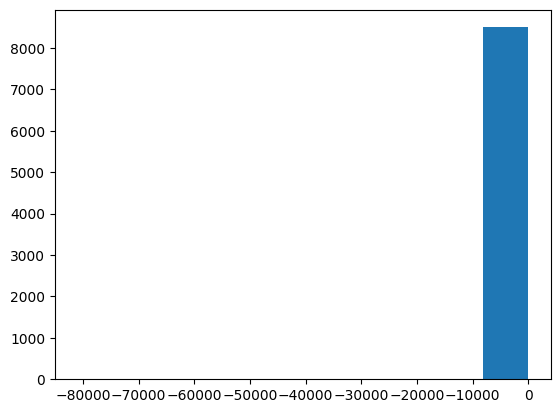

In [115]:
plt.hist(ecommerce_data[condition]['Quantity'])

In [117]:
ecommerce_data[condition]['Description'].value_counts().head(10)

Description
REGENCY CAKESTAND 3 TIER              180
JAM MAKING SET WITH JARS               86
SET OF 3 CAKE TINS PANTRY DESIGN       72
STRAWBERRY CERAMIC TRINKET BOX         54
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
JUMBO BAG RED RETROSPOT                44
WOOD 2 DRAWER CABINET WHITE FINISH     42
WHITE HANGING HEART T-LIGHT HOLDER     42
LUNCH BAG RED RETROSPOT                42
Name: count, dtype: int64

In [119]:
ecommerce_data[ecommerce_data['CustomerID']=='17548'].sort_values(by='InvoiceDate')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
113327,550755,22926,IVORY GIANT GARDEN THERMOMETER,4,2011-04-20 12:01:00,5.95,17548,United Kingdom
113326,550755,22079,RIBBON REEL HEARTS DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom
113324,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548,United Kingdom


# Cancelled Transactions are refunded transactions for the customers after they cancelled their orders, this data is directly affecting the sales only when it had an recorded order beforehand. (For example: the cancelled Invoice on 2010-12-01 does not make sense since it lacks it's cancelled order since the data is recorded from 2010-12-01)

In [ ]:
# Cancelled transactions with negative quantity are transactions that had description containing the returned product
ecommerce_data[ecommerce_data['CustomerID']=='17548'].head()

In [54]:
# exclude cancelled orders
# ecommerce_data = ecommerce_data[~ecommerce_data['InvoiceNo'].str.contains('C')]

ecommerce_data['M'] = ecommerce_data['Quantity'] * ecommerce_data['UnitPrice']
agg_table = ecommerce_data.groupby('CustomerID').agg({'M':'sum'}).sort_values(by='M', ascending=True)

In [ ]:
ecommerce_data[ecommerce_data['CustomerID'] == '17448.0']

In [ ]:
ecommerce_data[ecommerce_data['InvoiceNo'].str.contains('C')].head(10)

In [ ]:
ecommerce_data[ecommerce_data['CustomerID'] == '14527.0'].sort_values(by='InvoiceDate', ascending=True).head(10)

In [ ]:
ecommerce_data[ecommerce_data['CustomerID'] == '14527.0'].groupby('CustomerID').agg({'M':'sum'}).sort_values(by='M', ascending=True).head()

In [ ]:
agg_table.shape

In [ ]:
agg_table = agg_table[agg_table['M'] > 0]

In [ ]:
plt.boxplot(agg_table['M'])

In [ ]:
R = [1,2,3,4,5]
F = [1,2,3,4,5]
M = [1,2,3,4,5]

# III. RFM Analysis

## 3.1. Recency

## 3.2. Frequency

## 3.3. Monetary

# IV. Recommendations